***Install Dependencies***



In [1]:
!pip install -q datasets scikit-learn matplotlib seaborn arabic-reshaper python-bidi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 32.6 MB/s eta 0:00:0000:0100:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


***Imports***

In [ ]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#hardware check - should be cude/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#BiLSTM
model_name = "BiLSTM-baseline"
print(f"Model Selected: {model_name}")


Using device: cuda
Model Selected: BiLSTM-baseline


***Cleaning Function***

In [ ]:
print("Cleaning Function")

def advanced_clean(text):
    text = str(text)
    #remove Tashkeel (Diacritics)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    #remove Tatweel (Elongation)
    text = re.sub(r'ـ', '', text)
    #normalize Alef letter
    text = re.sub(r'[إأآ]', 'ا', text)
    #normalize Taa Marbuta letter
    text = re.sub(r'ة', 'ه', text)
    #normalize Yaa letter
    text = re.sub(r'ى', 'ي', text)
    #remove Numbers
    text = re.sub(r'\d+', '', text)
    #remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #remove extra Whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


Cleaning Function


***Load Dataset***

In [4]:
print("⬇ Loading dataset.")
dataset = load_dataset("omkarthawakar/FannOrFlop")

df = dataset["train"].to_pandas()[["poem_verses", "era"]].dropna()

print("Applying Advanced Cleaning.")
print("Before:", df["poem_verses"].iloc[0][:80])
df["poem_verses"] = df["poem_verses"].apply(advanced_clean)
print("After :", df["poem_verses"].iloc[0][:80])

df.head()


⬇ Loading dataset.


README.md: 0.00B [00:00, ?B/s]

dataset.json:   0%|          | 0.00/99.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6984 [00:00<?, ? examples/s]

Applying Advanced Cleaning.
Before: 1

حَيّـاكُمُ اللَـهُ أَحيـوا العِلمَ وَالأَدَبا

إِن تَنشُروا العِلمَ يَنشُر في
After : حياكم اللةاحيوا العلم والادبا ان تنشروا العلم ينشر فيكم العربا ولا حياة لكم الا 


,poem_verses,era
0,حياكم اللةاحيوا العلم والادبا ان تنشروا العلم ...,العصر الحديث
1,غاب الاديب اديب مصر واختفى فلتبكةالاقلام او تت...,العصر الحديث
2,عثمان انك قد اتيت موفقا شروى سميك جامع التنزيل...,العصر الحديث
3,ان عضيك يا اخىبالملام لا يؤدىلمثل هذا الخصام ا...,العصر الحديث
4,من واجد منقر المنام طريد دهر جائر الاحكام مشتت...,العصر الحديث


***Split & Encode Labels***



In [ ]:
print("Split & Encode Labels")

#encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["era"])

label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label  = {idx: label for label, idx in label2id.items()}

print("Classes:", list(le.classes_))

#stratified split
train_df, val_df = train_test_split(
    df,
    test_size= 0.2, #this goes to val_df
    stratify = df["label"], #ensure class distribution is preserved
    random_state = 42, #stability so every time we run code we get same split
)

print(f"Train size: {len(train_df)}")
print(f"Val size  : {len(val_df)}")

train_df["label"].value_counts()


Split & Encode Labels
Classes: ['الدولة الايوبية', 'الدولة الفاطمية', 'الدولة المملوكية', 'الشعراء المخضرمون', 'العصر الأموي', 'العصر الإسلامي', 'العصر الحديث', 'العصر العباسي', 'العصر العثماني', 'المغرب والأندلس', 'عصر بين الدولتين', 'قبل الإسلام']
Train size: 5587
Val size  : 1397


label
7     1874
6      560
4      454
9      357
0      330
1      327
2      326
3      307
11     299
8      261
10     257
5      235
Name: count, dtype: int64

***Balance Data (Upsampling)***

In [ ]:
print("Balancing training data.")
#to make all class of equal sizes
max_size = train_df["label"].value_counts().max()#counting samples in each class
balanced_parts = []

for label_id in train_df["label"].unique(): #looping over each class
    subset = train_df[train_df["label"] == label_id]
    upsampled = resample(
        subset,
        replace = True,
        n_samples = max_size,
        random_state = 42,
    )
    balanced_parts.append(upsampled)

train_df_balanced = pd.concat(balanced_parts)
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced train size:", len(train_df_balanced))
train_df_balanced["label"].value_counts()

Balancing training data.
Balanced train size: 22488


label
0     1874
5     1874
9     1874
10    1874
2     1874
4     1874
8     1874
3     1874
6     1874
11    1874
7     1874
1     1874
Name: count, dtype: int64

***Tokenization***

In [ ]:
print("Tokenization for BiLSTM")

from collections import Counter #use it for counting word appearance

#after text normalization done this is tokenization using whitespace
def tokenize(text):
    return text.split()

#looping over training data to count frequency of all words - no validation leakage :)
def build_vocab(texts, min_freq = 2):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    #special tokens - <PAD> to pad short poems to a fixed length
    #and <UNK> used when validation set contains unseen words
    stoi = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq: #min_freq is 2, so words appearing once are discarded
            stoi[word] = len(stoi)
    return stoi

print("Building vocabulary from balanced training set...")
stoi = build_vocab(train_df_balanced["poem_verses"].tolist(), min_freq=2)
itos = {i: s for s, i in stoi.items()} #map index to string
vocab_size = len(stoi)
print("Vocab size:", vocab_size)

MAX_LEN = 100

def encode_text(text, stoi, max_len = MAX_LEN):
    tokens = tokenize(text) #tokenize
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in tokens][:max_len] #convert words to IDs - unknown words are <UNK> and long poem are truncated
    if len(ids) < max_len:
        ids += [stoi["<PAD>"]] * (max_len - len(ids)) #padding if short
    return ids

print("Encoding train and validation texts...")

X_train = np.vstack([
    encode_text(t, stoi, MAX_LEN)
    for t in train_df_balanced["poem_verses"]
])
y_train = train_df_balanced["label"].values

X_val = np.vstack([
    encode_text(t, stoi, MAX_LEN)
    for t in val_df["poem_verses"]
])
y_val = val_df["label"].values

print("X_train shape:", X_train.shape)
print("X_val shape  :", X_val.shape)


Tokenization for BiLSTM
Building vocabulary from balanced training set...
Vocab size: 166123
Encoding train and validation texts...
X_train shape: (22488, 100)
X_val shape  : (1397, 100)


In [ ]:
print("Creating PyTorch Dataset and DataLoader")

#our custom dataset class
class PoetryDataset(Dataset):
    #constructor
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    #fetching one sample
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#creatinf dataset object - one for train and one for val
train_dataset = PoetryDataset(X_train, y_train) #balanced
val_dataset = PoetryDataset(X_val, y_val) #original distribution of data

BATCH_SIZE = 64

#creating DataLoader - shuffling train only
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

print("Number of train batches:", len(train_loader))
print("Number of val batches  :", len(val_loader))


Creating PyTorch Dataset and DataLoader
Number of train batches: 352
Number of val batches  : 22


***Initialize Model***

In [ ]:
print("Initialize Model")

#our class
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout = 0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)

        self.lstm = nn.LSTM(
            input_size = embed_dim, #each tie step is aword emb vector
            hidden_size = hidden_dim, #
            num_layers = num_layers, #2
            batch_first = True,
            bidirectional = True,
            dropout = dropout if num_layers > 1 else 0.0, #dropout only between layers
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes) #forward (hidden_dim) and backward (hidden_dim) so concatenate

    #forward pass
    def forward(self, x):
        #x: [batch, seq_len]
        emb = self.embedding(x) #x becomes [batch, seq_len, embed_dim]
        out, (h_n, c_n) = self.lstm(emb) #h_n is final hidden state for each layer
        #h_n shape is [num_layers*num_directions, batch, hidden_dim]
        #so in our case [2*2, batch, 256] >> [4, batch, 256]

        #but reshape to separate layers and directions!
        #becomes [num_layers, num_directions, batch, hidden_dim] >> [2, 2, batch, 256]
        num_layers = self.lstm.num_layers
        num_directions = 2
        h_n = h_n.view(num_layers, num_directions, x.size(0), self.lstm.hidden_size)

        last_layer_h = h_n[-1] #take last layer    
        h_forward = last_layer_h[0] #forwards  
        h_backward = last_layer_h[1] #backward   

        h_cat = torch.cat([h_forward, h_backward], dim=1) #concatenate
        h_cat = self.dropout(h_cat) #dropout
        logits = self.fc(h_cat) #logits will be fed to Cross Entropy Loss
        return logits

num_classes = len(le.classes_)

model = BiLSTMClassifier(
    vocab_size=vocab_size,
    embed_dim = 128,
    hidden_dim = 256,
    num_layers = 2,
    num_classes = num_classes,
    dropout = 0.3,
).to(device)

print("Model ready.")
model


Initialize Model
Model ready.


BiLSTMClassifier(
  (embedding): Embedding(166123, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=12, bias=True)
)

***Training Setup***

In [ ]:
print("Training Setup")

criterion = nn.CrossEntropyLoss() #loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) #optimizer and learning rate
EPOCHS = 10

#used for validation
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)

            #prediction is in shape of (samples, 12) and converted to argmax(axis=1)
            #which means selecting class with highest score
            preds = torch.argmax(logits, dim = 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average = "weighted")
    return avg_loss, acc, f1, np.array(all_labels), np.array(all_preds)


Training Setup


***Train Model***

In [ ]:
print("Train Model")

best_val_acc = 0.0 #tracking highest validation accuracy
best_state_dict = None #storing weights for best epoch

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        #backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y_batch.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with Val Acc = {best_val_acc:.4f}")


Train Model
Epoch 01/10 | Train Loss: 1.4884 | Val Loss: 4.1969 | Val Acc: 0.3364 | Val F1: 0.1725
Epoch 02/10 | Train Loss: 0.2134 | Val Loss: 3.9389 | Val Acc: 0.3393 | Val F1: 0.1946
Epoch 03/10 | Train Loss: 0.0510 | Val Loss: 3.4329 | Val Acc: 0.3386 | Val F1: 0.1935
Epoch 04/10 | Train Loss: 0.0290 | Val Loss: 3.9828 | Val Acc: 0.3364 | Val F1: 0.2064
Epoch 05/10 | Train Loss: 0.0192 | Val Loss: 4.0538 | Val Acc: 0.3286 | Val F1: 0.2053
Epoch 06/10 | Train Loss: 0.0261 | Val Loss: 4.5640 | Val Acc: 0.3400 | Val F1: 0.2137
Epoch 07/10 | Train Loss: 0.0123 | Val Loss: 4.6573 | Val Acc: 0.3386 | Val F1: 0.2117
Epoch 08/10 | Train Loss: 0.0174 | Val Loss: 4.4419 | Val Acc: 0.3393 | Val F1: 0.2365
Epoch 09/10 | Train Loss: 0.0036 | Val Loss: 4.7693 | Val Acc: 0.3214 | Val F1: 0.2172
Epoch 10/10 | Train Loss: 0.0247 | Val Loss: 4.9120 | Val Acc: 0.3364 | Val F1: 0.2193

Loaded best model with Val Acc = 0.3400


***Evaluate and Visualize***


Final Report :
Accuracy: 0.336, F1 (weighted): 0.219

                   precision    recall  f1-score   support

  الدولة الايوبية      0.333     0.012     0.023        83
  الدولة الفاطمية      0.000     0.000     0.000        82
 الدولة المملوكية      0.077     0.012     0.021        82
الشعراء المخضرمون      0.333     0.026     0.049        76
     العصر الأموي      0.385     0.088     0.143       114
   العصر الإسلامي      0.083     0.017     0.028        59
     العصر الحديث      0.267     0.171     0.209       140
    العصر العباسي      0.350     0.902     0.504       468
   العصر العثماني      0.333     0.046     0.081        65
  المغرب والأندلس      0.214     0.034     0.058        89
 عصر بين الدولتين      0.250     0.016     0.029        64
      قبل الإسلام      0.143     0.027     0.045        75

         accuracy                          0.336      1397
        macro avg      0.231     0.113     0.099      1397
     weighted avg      0.270     0.336     0.219      1397

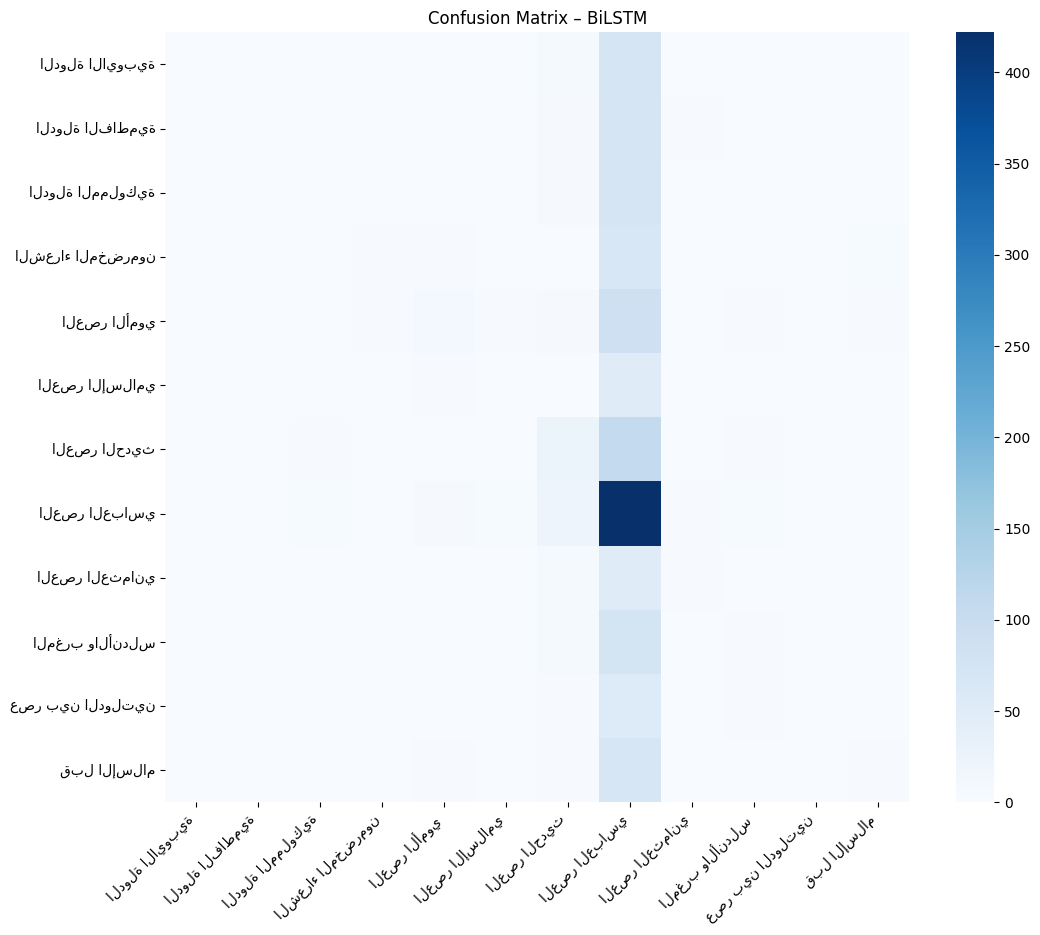

In [ ]:
print("\nFinal Report :")

val_loss, val_acc, val_f1, y_true, y_pred = evaluate(model, val_loader)
print(f"Accuracy: {val_acc:.3f}, F1 (weighted): {val_f1:.3f}\n")

#printing text report
print(classification_report(y_true, y_pred, target_names = le.classes_, digits = 3))


#visualizing Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot = False,
    cmap = "Blues",
    xticklabels = le.classes_,
    yticklabels = le.classes_,
)
plt.title("Confusion Matrix – BiLSTM")
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.show()


***Save Model and Tokenizer***

In [ ]:
import os
import json
save_dir = "./bilstm_poetry_final"
print(f"Saving model to {save_dir} .")

os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_dir, "bilstm_weights.pt"))

with open(os.path.join(save_dir, "stoi.json"), "w", encoding="utf-8") as f:
    json.dump(stoi, f, ensure_ascii=False)

with open(os.path.join(save_dir, "label_classes.json"), "w", encoding="utf-8") as f:
    json.dump(list(le.classes_), f, ensure_ascii=False)

print("Done.")


Saving model to ./bilstm_poetry_final .
Done.
